In [1]:
import gym
from gym import spaces

import pygame
import random
import numpy as np

import traceback

WIDTH, HEIGHT = 1005,  510
BLOCKSIZE = 15
get_random_apple = lambda: [random.randrange(1,int(WIDTH/BLOCKSIZE))*BLOCKSIZE,random.randrange(1,int(HEIGHT/BLOCKSIZE))*BLOCKSIZE]

class Snake:

    def __init__(self):

        x = random.randint(30, WIDTH-50)
        x -= x % BLOCKSIZE or 0
        #x = (lambda num: num - num % 15 or 1)(random.randint(100, 1000))

        y = random.randint(100, HEIGHT-50)
        y -= y % BLOCKSIZE or 0

        self.head = [x,y]
        self.tail = [[x+BLOCKSIZE,y],[x+(2*BLOCKSIZE),y],[x+(3*BLOCKSIZE),y]]


class SnakeEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(SnakeEnv, self).__init__()

        self.done = False #For episode
        self.run = True # For game window

        self.action_space = spaces.Discrete(4) #For left right up and down
        self.observation_space = spaces.Box(
            low=np.array([0 for _ in range(5)]),
            high=np.array([WIDTH, HEIGHT, WIDTH, HEIGHT, np.linalg.norm(np.array([WIDTH, HEIGHT]))]),
            shape=(5,),
            dtype=float) # 5 = Snake_X, Snake_Y, Apple_X, Apple_Y, Euclid_Distance_Apple_to_Snake        self.info = {}
        self.info = {}
        
        self.Agent = Snake()
        self.Apple = get_random_apple()

        self.distance = np.linalg.norm(np.array([self.Agent.head[0], self.Agent.head[1]]) - np.array([self.Apple[0], self.Apple[1]]))


    def step(self, action):

        self.render()

        reward = 0

        if action == 0: #left
            self.Agent.head[0] -= BLOCKSIZE

        if action == 1: #up
            self.Agent.head[1] -= BLOCKSIZE

        if action == 2: #right
            self.Agent.head[0] += BLOCKSIZE

        if action == 3: # down
            self.Agent.head[1] += BLOCKSIZE

        if np.linalg.norm(np.array([self.Agent.head[0], self.Agent.head[1]]) - np.array([self.Apple[0], self.Apple[1]])) < self.distance:
            # reward += 15
            reward += 5
        else:
            # reward -= 5
            pass

        self.distance = np.linalg.norm(np.array([self.Agent.head[0], self.Agent.head[1]]) - np.array([self.Apple[0], self.Apple[1]]))

        self.observation = np.array([self.Agent.head[0], self.Agent.head[1], self.Apple[0], self.Apple[1], self.distance])

        if self.Agent.head[1] < 0 or self.Agent.head[0] < 0 or self.Agent.head[1] > HEIGHT or self.Agent.head[0] > WIDTH:
            self.done = True

        if self.Apple == self.Agent.head:

            self.Agent.tail.insert(0,list(self.Agent.head))
            self.Apple = get_random_apple()
            self.distance = np.linalg.norm(np.array([self.Agent.head[0], self.Agent.head[1]]) - np.array([self.Apple[0], self.Apple[1]]))
            reward += 100

        return self.observation, reward, self.done, self.info


    def reset(self):

        self.Agent = Snake()
        self.Apple = get_random_apple()

        self.distance = np.linalg.norm(np.array([self.Agent.head[0], self.Agent.head[1]]) - np.array([self.Apple[0], self.Apple[1]]))

        self.observation = np.array([self.Agent.head[0], self.Agent.head[1], self.Apple[0], self.Apple[1], self.distance])
        self.done = False

        return self.observation


    def render(self):

        screen.fill((0,0,0))
        pygame.draw.rect(screen, (255,0,0), [self.Apple[0],self.Apple[1], BLOCKSIZE, BLOCKSIZE])

        for pos in self.Agent.tail:
            pygame.draw.rect(screen, (0,0,120), [pos[0], pos[1], BLOCKSIZE, BLOCKSIZE])

        self.Agent.tail.insert(0,list(self.Agent.head))
        self.Agent.tail.pop()

        for x in range(0, WIDTH, BLOCKSIZE):
            for y in range(0, HEIGHT, BLOCKSIZE):
                rect = pygame.Rect(x, y, BLOCKSIZE, BLOCKSIZE)
                pygame.draw.rect(screen, (25,25,25), rect, 1)

        pygame.display.update()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.run = False
                self.close()

In [3]:
from stable_baselines3 import PPO, A2C
import traceback
import sys

screen = pygame.display.set_mode((WIDTH,HEIGHT))


env = SnakeEnv()

try:
    model = A2C('MlpPolicy', env, learning_rate=0.0004, gamma=0.80, gae_lambda=0.95, max_grad_norm=0.5, verbose=0)

    #policy, env, learning_rate=0.0003, n_steps=2048, batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2,
    #clip_range_vf=None, normalize_advantage=True, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, use_sde=False, sde_sample_freq=-1,
    #target_kl=None, stats_window_size=100, tensorboard_log=None, policy_kwargs=None, verbose=0, seed=None, device='auto', _init_setup_model=True

    #model.learn(total_timesteps=500000, callback=None, log_interval=5, tb_log_name='PPO', reset_num_timesteps=True, progress_bar=True)

    """
    gamma = A higher gamma value (e.g., 0.99) means that the agent considers future rewards more heavily, which can lead to a longer-term focus in its learning. Conversely, a lower gamma value (e.g., 0.9) makes the agent prioritize immediate rewards.
    gae_lambda = is the factor used for trade-off between bias and variance when estimating advantages with the Generalized Advantage Estimator (GAE). GAE is used to estimate how much better or worse taking a specific action is compared to following the current policy. A higher gae_lambda value (e.g., 0.95) reduces bias but may increase variance, while a lower value reduces variance but may introduce bias into the advantage estimates.
    max_grad_norm = is the maximum allowed value for gradient clipping during the training process. Gradient clipping is a technique used to prevent exploding gradients, which can lead to unstable training. If the magnitude of the gradients exceeds this value, they are scaled down to ensure they do not become too large.
    """

except Exception as e:
    exc_type, exc_obj, tb = sys.exc_info()
    line_number = tb.tb_lineno
    print("!Error at", line_number,"th Line")
    traceback.print_exc()
    pygame.quit()


/Users/mihirmishra/opt/anaconda3/envs/cs4756_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


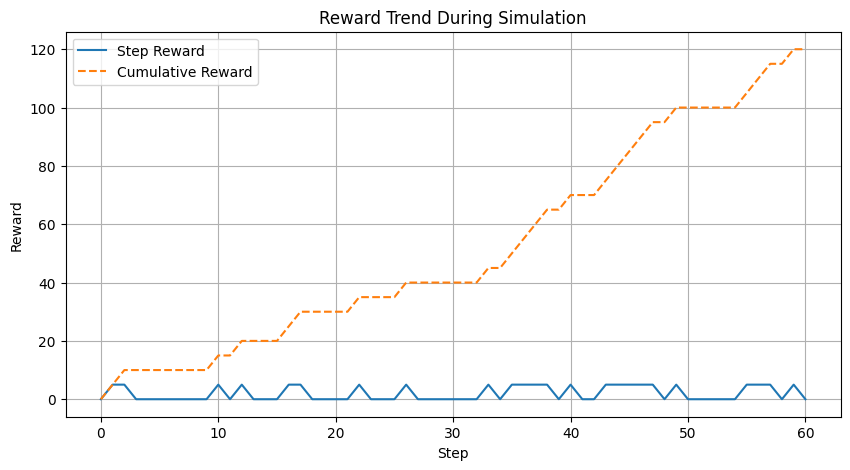

In [4]:
from IPython.display import Video, display
import cv2
import matplotlib.pyplot as plt
import pygame
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video, display
from tqdm import tqdm

def visualize(env, model=None, video_name="test", plot_name=None):
    def get_action(obs):
        if not model:
            return env.action_space.sample()
        else:
            action, _ = model.predict(obs, deterministic=False)
            return action

    obs = env.reset()

    # Initialize variables for tracking rewards
    rewards = []
    cumulative_rewards = []
    frames = []  # List to store captured frames

    # Run the environment
    total_reward = 0
    for _ in range(600):
        action = get_action(obs)
        obs, reward, terminated, info = env.step(action)
        env.render()  # Render to screen

        # Capture the screen
        frame = pygame.surfarray.array3d(pygame.display.get_surface())
        frame = cv2.cvtColor(cv2.transpose(frame), cv2.COLOR_RGB2BGR)  # Adjust for OpenCV
        frames.append(frame)

        # Track rewards
        rewards.append(reward)
        total_reward += reward
        cumulative_rewards.append(total_reward)

        if terminated:
            break

    # Save video using captured frames
    video_path = f"{video_name}.mp4"
    fps = 20
    frame_height, frame_width, _ = frames[0].shape  # Access frame dimensions

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))

    for frame in frames:
        video_writer.write(frame)

    video_writer.release()

    # Plot the rewards
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Step Reward")
    plt.plot(cumulative_rewards, label="Cumulative Reward", linestyle='--')
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title("Reward Trend During Simulation")
    plt.legend()
    plt.grid()
    if plot_name:
        plt.savefig(plot_name+".pdf")
    else:
        plt.show()

    return video_path

# Example usage
# env = SnakeEnv()
# video_path = visualize(env)
video_path = visualize(env, model=model)
display(Video(video_path, embed=True))

In [18]:
model.save("Snake_Model")

/Users/mihirmishra/opt/anaconda3/envs/cs4756_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/mihirmishra/opt/anaconda3/envs/cs4756_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
2024-12-11 01:27:43.229 python[44858:40548894] +[IMKClient subclass]: chose IMKClient_Legacy
2024-12-11 01:27:43.229 python[44858:40548894] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


!Error at 5 th Line


Traceback (most recent call last):
  File "/var/folders/dn/zvn6jgsj7c5bbww7rzdblz1w0000gn/T/ipykernel_44858/2344269621.py", line 5, in <module>
    model = A2C(policy_type, env, learning_rate=0.0004, gamma=0.80, gae_lambda=0.95, max_grad_norm=0.5, verbose=0)
  File "/Users/mihirmishra/opt/anaconda3/envs/cs4756_env/lib/python3.10/site-packages/stable_baselines3/a2c/a2c.py", line 92, in __init__
    super().__init__(
  File "/Users/mihirmishra/opt/anaconda3/envs/cs4756_env/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py", line 86, in __init__
    super().__init__(
  File "/Users/mihirmishra/opt/anaconda3/envs/cs4756_env/lib/python3.10/site-packages/stable_baselines3/common/base_class.py", line 123, in __init__
    self.policy_class = self._get_policy_from_name(policy)
  File "/Users/mihirmishra/opt/anaconda3/envs/cs4756_env/lib/python3.10/site-packages/stable_baselines3/common/base_class.py", line 338, in _get_policy_from_name
    raise ValueError(f"Policy {p

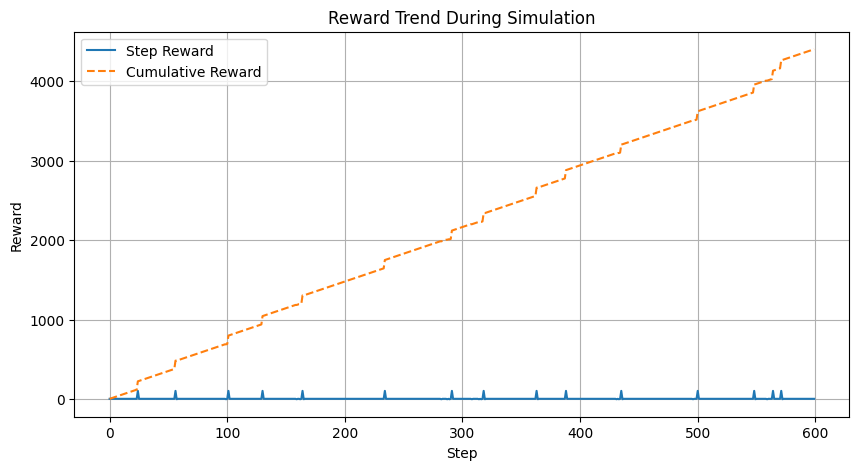

In [5]:
for policy_type in ["MlpPolicy", "MlpLstmPolicy", "CnnPolicy", "CnnLstmPolicy"]:
  try:
      env = SnakeEnv()
      env.reset()
      model = A2C(policy_type, env, learning_rate=0.0004, gamma=0.80, gae_lambda=0.95, max_grad_norm=0.5, verbose=0)
      model.learn(total_timesteps=500000, callback=None, log_interval=5, tb_log_name='PPO', reset_num_timesteps=True, progress_bar=True)
      model.save("Snake_Model_" + policy_type)
      visualize(env, model=model, video_name="Snake_" + policy_type, plot_name="Snake_" + policy_type)

  except Exception as e:
      exc_type, exc_obj, tb = sys.exc_info()
      line_number = tb.tb_lineno
      print("!Error at", line_number,"th Line")
      traceback.print_exc()
      pygame.quit()
      break